In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
def generate_smiley_face(num_points,noise=0.05):

    left_eye_x = np.array([-0.3]*(num_points//50))+ np.random.randn(num_points//50) * noise
    left_eye_y = np.array([0.3]*(num_points//50))+ np.random.randn(num_points//50)* noise


    right_eye_x = np.array([0.3]*(num_points//50)) + np.random.randn(num_points//50) * noise
    right_eye_y = np.array([0.3]*(num_points//50)) + np.random.randn(num_points//50) * noise



    smile_theta = -np.linspace(np.pi/6, 5*np.pi/6, num_points//10)
    smile_x = 0.5 * np.cos(smile_theta)+ np.random.randn(num_points//10) * noise
    smile_y = 0.5 * np.sin(smile_theta) + np.random.randn(num_points//10) * noise

    rem_points = num_points - (len(smile_theta)+len(left_eye_x)*2)

    theta = np.linspace(0, 2*np.pi, rem_points)
    face_x = np.cos(theta) + np.random.randn(rem_points) * noise
    face_y = np.sin(theta) + np.random.randn(rem_points) * noise


    return (np.concatenate([face_x, left_eye_x, right_eye_x, smile_x]),
           np.concatenate([face_y, left_eye_y, right_eye_y, smile_y]))


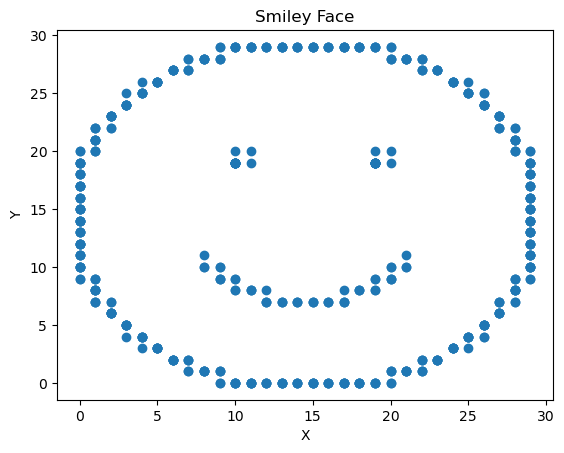

In [5]:
face = generate_smiley_face(500,noise=0)
new_face_x = np.ones((face[0].shape[0]+6,))
new_face_y = np.ones((face[1].shape[0]+6,))
new_face_x[:6] = [10,11,19,20,11,20]
new_face_y[:6] = [20,20,20,20,19,19]
new_face_x[6:] = ((face[0]+1)*15)//1
new_face_y[6:] = ((face[1]+1)*15)//1
new_face_x =np.clip(new_face_x,a_min=0,a_max=29)
coords = np.stack((new_face_x, new_face_y), axis=1)
unique_coords = np.unique(coords, axis=0)
new_face_x_ = unique_coords[:, 0]
new_face_y_= unique_coords[:, 1]

plt.scatter(new_face_x, new_face_y)
plt.title('Smiley Face')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [6]:
def bi_interpolant(x0,x1,t,scheduler):

    num_pts = x0.shape[0]
    pt = torch.zeros(num_pts*2,30,device=device).to(dtype=torch.float32)

    pt[torch.arange(num_pts),x0[:,0]] = scheduler(1-t)
    pt[torch.arange(num_pts),x1[:,0]] += scheduler(t)

    pt[torch.arange(num_pts,num_pts*2),x0[:,1]] = scheduler(1-t)
    pt[torch.arange(num_pts,num_pts*2),x1[:,1]] += scheduler(t)

    return torch.multinomial(pt,1).reshape(2,num_pts).T


In [7]:
def one_hot(x,dis_size):
    y = torch.zeros(len(x),dis_size[0]+dis_size[1],device=device)
    y[torch.arange(len(y)),x[:,0]] = 1
    y[torch.arange(len(y)),dis_size[0]+x[:,1]] = 1
    return y

In [8]:
def linear_scheduler(t):
    return t

def d_linear_scheduler(t):
    return 1
    
def cosine_scheduler(t):
    return 1 - torch.cos(t*np.pi/2)

def d_cosine_scheduler(t):
    return (np.pi/2)*torch.sin(t*np.pi/2)

In [21]:
def plot_time_evolution(xts):
    fig, axs = plt.subplots(2,5,figsize=(16,6))
    
    i=j=0
    for k in np.linspace(0,len(xts)-1,10):
        if j!=0 and j%5==0:
            i+=1
            j=0
        k = int(k)
        axs[i,j].scatter(xts[k][:1000,0].detach().cpu(),xts[k][:1000,1].detach().cpu(),alpha=0.2)
        axs[i,j].set_title(f"t={abs(start_t-k/len(xts)):.2f}")
        
        
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        j+=1

In [9]:
def get_t_encodings(t,num_freqs):

    enc = torch.full((t.shape[0],num_freqs*2+1),2,dtype=torch.float32).to(device)
    p = torch.arange(num_freqs)[None,:].to(device)
    enc[:,1:num_freqs+1] = (enc[0,:num_freqs]**p)[:,None,:]*t*np.pi
    enc[:,num_freqs+1:] = enc[:,1:num_freqs+1]
    enc[:,1:num_freqs+1] = torch.sin(enc[:,1:num_freqs+1])
    enc[:,num_freqs+1:] = torch.cos(enc[:,num_freqs+1:])
    enc[:,0] = t[:,0]
    return enc

num_hid_layers = 3
hid_size = 256
num_freq = 5
discrete_dim = (30,30)
model = nn.Sequential(
        nn.Linear(discrete_dim[0]+discrete_dim[1]+num_freq*2+1,hid_size),
        nn.ReLU(),
        *[m for _ in range(num_hid_layers) for m in (nn.Linear(hid_size, hid_size), nn.ReLU())],
        nn.Linear(hid_size,discrete_dim[0]+discrete_dim[1])
)

model = model.to(device)

In [10]:
X0 = torch.randint(0,discrete_dim[0],(1000,len(discrete_dim)),device=device)
X1 = torch.from_numpy(unique_coords).to(device=device,dtype=torch.int64).to(device)

print_every = 20
learning_rate = 1e-3
weight_decay=1e-5
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
num_epoch = 1000
mb_size = 128
CE_loss =  torch.nn.CrossEntropyLoss()

scheduler = cosine_scheduler
d_scheduler = d_cosine_scheduler
for e in range(num_epoch):
    if e%print_every == 0:
        acc_loss = 0
    for b in range(len(X0)//mb_size + 1):
        x0_ind = torch.randint(0,len(X0),(mb_size,))
        x1_ind = torch.randint(0,len(X1),(mb_size,))
        
        x0 = X0[x0_ind]
        x1 = X1[x1_ind]
        
        rand_time = torch.rand((mb_size,1),device=device)
        enc_rand_time = get_t_encodings(rand_time,num_freq)
        
        xt = bi_interpolant(x0,x1,rand_time[0],scheduler)
        
        cond_logit = model(torch.concat((one_hot(xt,discrete_dim),enc_rand_time),axis=1)).reshape(mb_size*2,-1)
        
        optimizer.zero_grad()
        loss = CE_loss(cond_logit,x1.flatten())
        
        loss.backward()
        
        optimizer.step()
        
        acc_loss += loss.item()
    if e%print_every == 0:
        print(f"epoch:{e} loss: {acc_loss/(b*print_every)}")



epoch:0 loss: 0.19327489137649537
epoch:20 loss: 0.13774474007742746
epoch:40 loss: 0.13721096004758562
epoch:60 loss: 0.104940898503576
epoch:80 loss: 0.12779980642454966
epoch:100 loss: 0.1503329506942204
epoch:120 loss: 0.1436118170619011
epoch:140 loss: 0.11793519662959236
epoch:160 loss: 0.1171977671129363
epoch:180 loss: 0.10376335148300443
epoch:200 loss: 0.129843817917364
epoch:220 loss: 0.0737681331379073
epoch:240 loss: 0.09552563322441919
epoch:260 loss: 0.06554780602455139
epoch:280 loss: 0.120652367493936
epoch:300 loss: 0.13395015607987132
epoch:320 loss: 0.12909688864435467
epoch:340 loss: 0.08577446937561035
epoch:360 loss: 0.13018204825265067
epoch:380 loss: 0.12163848195757185
epoch:400 loss: 0.10151624626346997
epoch:420 loss: 0.08366893944995744
epoch:440 loss: 0.12932838914649827
epoch:460 loss: 0.11880000616822924
epoch:480 loss: 0.09830959694726127
epoch:500 loss: 0.1334086841770581
epoch:520 loss: 0.10849533549376897
epoch:540 loss: 0.0822388829929488
epoch:560 

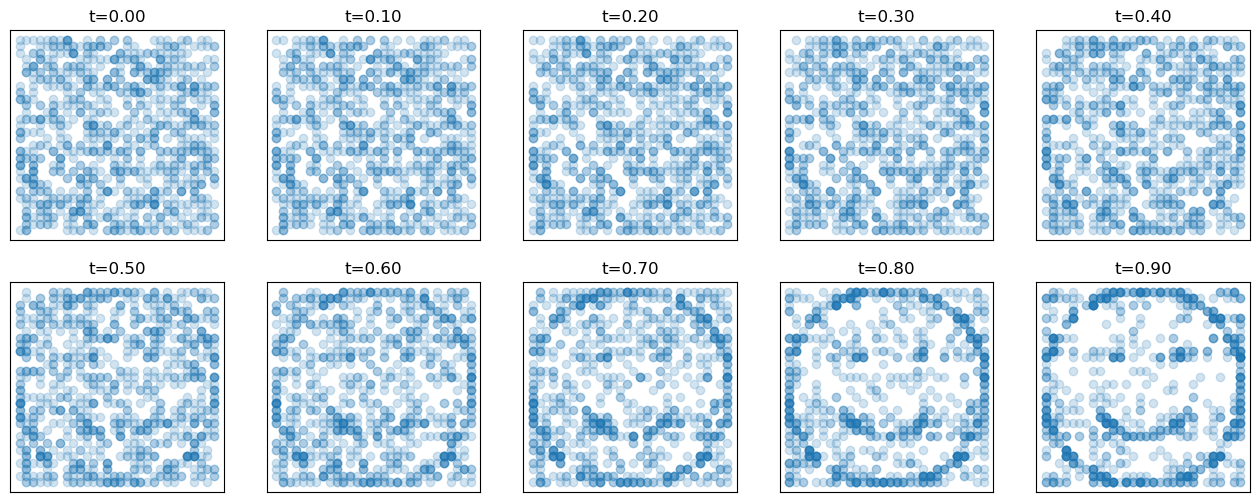

In [27]:
with torch.no_grad():
    num_test_samples = 1000
    start_t = 0.0
    end_t = 1.0-start_t
    
        
    num_time_steps = 10
    step_size = (end_t-start_t)/num_time_steps
    X0_test = torch.randint(0,discrete_dim[0],(num_test_samples,len(discrete_dim)))
    Xt = X0_test.clone()
    t = torch.full((len(Xt),1),start_t).to(device)
    xts = []
    while t[0] < 0.999:
        h = min(step_size,(1-scheduler(t[0]))/d_scheduler(t[0]))
        cond_logit = model(torch.concat((one_hot(Xt,discrete_dim),get_t_encodings(t,num_freq)),axis=1)).reshape(num_test_samples*2,-1)
        cond_prob = F.softmax(cond_logit,dim=1)
        cond_prob[torch.arange(num_test_samples*2),Xt.flatten()] -= 1
        
        cond_prob = cond_prob.reshape(num_test_samples,2,-1) * d_scheduler(t[:,:,None])/(1-scheduler(t[:,:,None]))
        cond_prob *= h
        cond_prob = cond_prob.reshape(num_test_samples*2,-1)
        
        cond_prob[torch.arange(num_test_samples*2),Xt.flatten()] += 1

        
        Xt = torch.multinomial(torch.clamp(cond_prob,0,1),1,).reshape(-1,2)
        t += h
        xts.append(Xt.detach().cpu().clone())
plot_time_evolution(xts)

## Stochastic sampling

In [28]:
def alpha_scheduler(t,ita=10):
    return 1 + t*ita

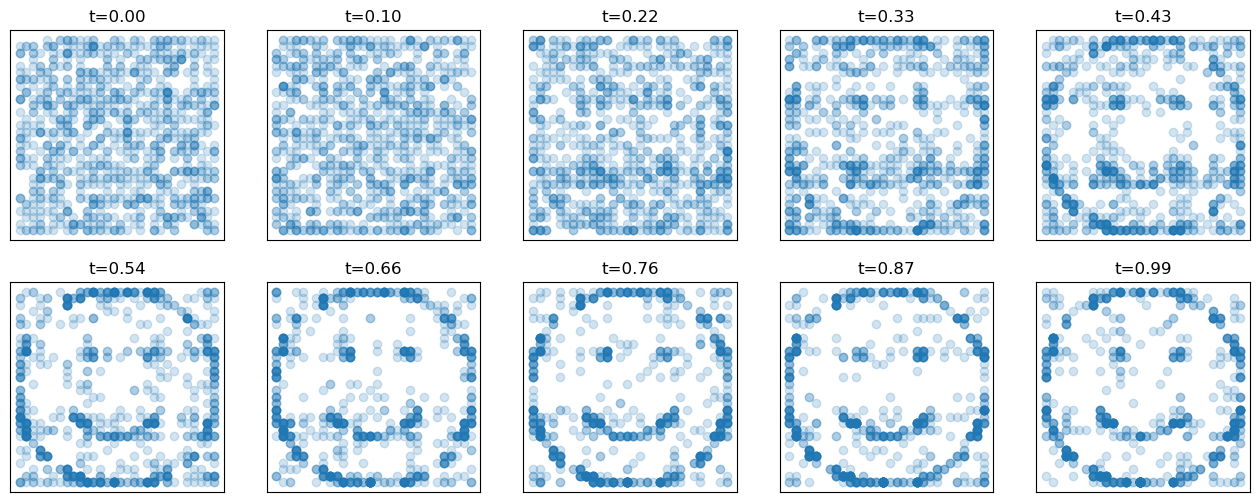

In [26]:
with torch.no_grad():
    num_test_samples = 1000
    start_t = 0.0
    end_t = 1.0-start_t
    
        
    num_time_steps = 10
    step_size = (end_t-start_t)/num_time_steps
    X0_test = torch.randint(0,discrete_dim[0],(num_test_samples,len(discrete_dim)))
    Xt = X0_test.clone()
    t = torch.full((len(Xt),1),start_t).to(device)
    xts = []
    while t[0] < 0.999:
        h = min(step_size,1/((alpha_scheduler(t[0])*d_scheduler(t[0]))/(1-scheduler(t[0]))+((alpha_scheduler(t[0])-1)*d_scheduler(t[0]))/(scheduler(t[0]))))
        
        cond_logit = model(torch.concat((one_hot(Xt,discrete_dim),get_t_encodings(t,num_freq)),axis=1)).reshape(num_test_samples*2,-1)
        cond_prob = F.softmax(cond_logit,dim=1)
        u_hat = cond_prob
        u_hat[torch.arange(num_test_samples*2),Xt.flatten()] -= 1
        
        u_hat = u_hat.reshape(num_test_samples,2,-1) * d_scheduler(t[:,:,None])/(1-scheduler(t[:,:,None]))

        u_tah = torch.full_like(cond_prob,1/discrete_dim[0],device=device)
        u_tah[torch.arange(num_test_samples*2),Xt.flatten()] -= 1
        u_tah =  -u_tah.reshape(num_test_samples,2,-1) * d_scheduler(t[:,:,None])/(scheduler(t[:,:,None])+1e-8)

        u = alpha_scheduler(t[:,:,None])*u_hat - (alpha_scheduler(t)[:,:,None]-1)* u_tah 
        
        u *= h
        u = u.reshape(num_test_samples*2,-1)
        
        u[torch.arange(num_test_samples*2),Xt.flatten()] += 1
        Xt = torch.multinomial(torch.clamp(u,0,1),1,).reshape(-1,2)
        t += h
        xts.append(Xt.detach().cpu().clone())
plot_time_evolution(xts)

## Predictor Corrector Sampling

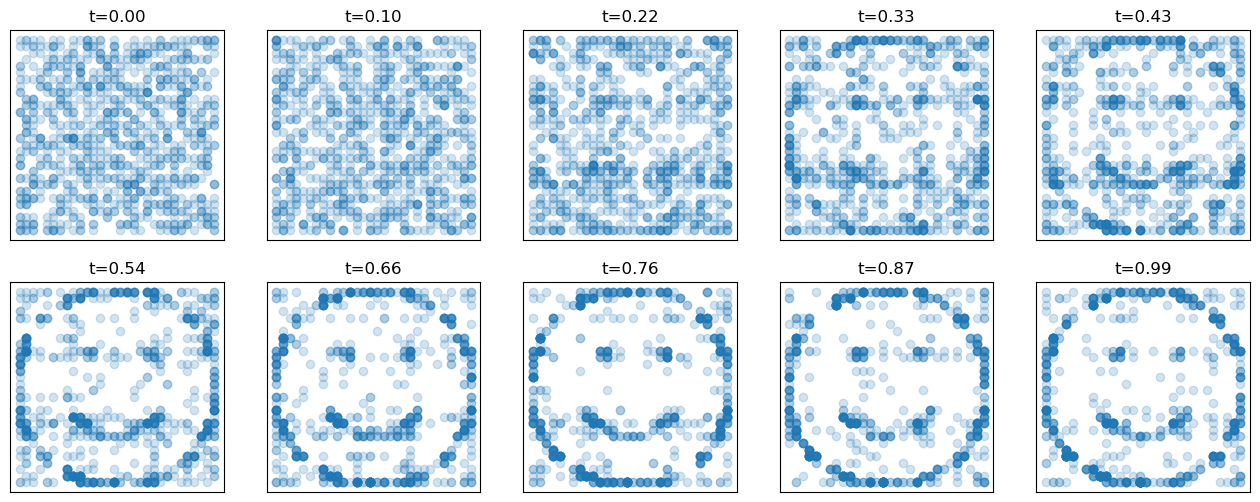

In [37]:
with torch.no_grad():
    num_test_samples = 1000
    start_t = 0.0
    end_t = 1.0-start_t
    
    num_corrector_steps = 2
        
    num_time_steps = 10
    step_size = (end_t-start_t)/num_time_steps
    X0_test = torch.randint(0,discrete_dim[0],(num_test_samples,len(discrete_dim)))
    Xt = X0_test.clone()
    t = torch.full((len(Xt),1),start_t).to(device)
    xts = []
    while t[0] < 0.999:
        h = min(step_size,1/((alpha_scheduler(t[0])*d_scheduler(t[0]))/(1-scheduler(t[0]))+((alpha_scheduler(t[0])-1)*d_scheduler(t[0]))/(scheduler(t[0]))))
        
        cond_logit = model(torch.concat((one_hot(Xt,discrete_dim),get_t_encodings(t,num_freq)),axis=1)).reshape(num_test_samples*2,-1)
        cond_prob = F.softmax(cond_logit,dim=1)
        u_hat = cond_prob
        u_hat[torch.arange(num_test_samples*2),Xt.flatten()] -= 1
        
        u_hat = u_hat.reshape(num_test_samples,2,-1) * d_scheduler(t[:,:,None])/(1-scheduler(t[:,:,None]))

        u_tah = torch.full_like(cond_prob,1/discrete_dim[0],device=device)
        u_tah[torch.arange(num_test_samples*2),Xt.flatten()] -= 1
        u_tah =  -u_tah.reshape(num_test_samples,2,-1) * d_scheduler(t[:,:,None])/(scheduler(t[:,:,None])+1e-8)

        u = alpha_scheduler(t[:,:,None])*u_hat - (alpha_scheduler(t)[:,:,None]-1)* u_tah 
        
        u *= h
        u = u.reshape(num_test_samples*2,-1)
        
        u[torch.arange(num_test_samples*2),Xt.flatten()] += 1
        Xt = torch.multinomial(torch.clamp(u,0,1),1,).reshape(-1,2)

        for _ in range(num_corrector_steps):
            cond_logit = model(torch.concat((one_hot(Xt,discrete_dim),get_t_encodings(t,num_freq)),axis=1)).reshape(num_test_samples*2,-1)
            cond_prob = F.softmax(cond_logit,dim=1)
            u_hat = cond_prob
            u_hat[torch.arange(num_test_samples*2),Xt.flatten()] -= 1
            
            u_hat = u_hat.reshape(num_test_samples,2,-1) * d_scheduler(t[:,:,None])/(1-scheduler(t[:,:,None]))
    
            u_tah = torch.full_like(cond_prob,1/discrete_dim[0],device=device)
            u_tah[torch.arange(num_test_samples*2),Xt.flatten()] -= 1
            u_tah =  -u_tah.reshape(num_test_samples,2,-1) * d_scheduler(t[:,:,None])/(scheduler(t[:,:,None])+1e-8)
    
            u = alpha_scheduler(t[:,:,None])*(u_hat - u_tah) 
            
            u *= h
            u = u.reshape(num_test_samples*2,-1)
            
            u[torch.arange(num_test_samples*2),Xt.flatten()] += 1
            Xt = torch.multinomial(torch.clamp(u,0,1),1,).reshape(-1,2)
            
        t += h
        xts.append(Xt.detach().cpu().clone())
plot_time_evolution(xts)